<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/BERT/BERTimbau_com_amostras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
! pip install transformers

In [78]:

!pip install torch==1.8.1 torchvision==0.9.1 torchaudio==0.8.


  Using cached torch-1.8.1-cp37-cp37m-manylinux1_x86_64.whl (804.1 MB)
  Using cached torchvision-0.9.1-cp37-cp37m-manylinux1_x86_64.whl (17.4 MB)
  Using cached torchaudio-0.8.0-cp37-cp37m-manylinux1_x86_64.whl (1.9 MB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of <Python from Requires-Python> to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install torch==1.8.1, torchaudio==0.8.0 and torchvision==0.9.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.8.1
    torchvision 0.9.1 depends on torch==1.8.1
    torchaudio 0.8.0 depends on torch==1.8.0

To fix this you could try to

In [79]:
!nvidia-smi

Sun Aug  1 19:42:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    31W /  70W |   4608MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [80]:
# Libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from datetime import datetime
from google.colab import files, drive

# Preliminaries

from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads
from transformers import AutoModel  # or BertModel, for BERT without pretraining heads

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

### Carregando tokens e vocabulário do BERTimbau

In [81]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [82]:
tokenizer

PreTrainedTokenizerFast(name_or_path='neuralmind/bert-base-portuguese-cased', vocab_size=29794, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

### Preparando DataSet
https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b

In [83]:
#!rm *.csv
#!!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/train.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/valid.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/test.csv
#!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/miscelanea.csv
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab\ Notebooks
path = '/gdrive/My Drive/Colab Notebooks'
KEY='4/1AX4XfWiQe0_gzMbt_ESEYXu4XM6IA5-fzg63z5pT8Hgf8_lGAjxUXwlE5uU'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Notebooks


In [ ]:
#%cd amostra_news_integrada
#!unzip drive-download-20210731T211249Z-001.zip
#!ls -lh

#!mkdir bertimbau_all_categ


In [29]:
#!mkdir ./bertimbau_all_categ/amostra_4


In [84]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [85]:
source_folder = './amostra_news_integrada/amostra_' #'/content'
destination_folder = './bertimbau_all_categ/amostra_' #'/content'


In [14]:
!ls ./amostra_news_integrada

test.csv  train.csv  valid.csv


In [118]:
#https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
#Model hyper-parameter
MAX_SEQ_LEN = 128 #limita os artigos em 128 tokens. Bert é limitado em 512 tokens por texto (checar isto e aplicar limpeza nos textos).
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
bs = 16
lr = 1e-4
qtd_categories=11
qtd_amostra=4

# Fields - use_vocab=False  e tokenizer.encode permite que utilizemos os tokens do BERTimbau.
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field),('label', label_field)]





In [87]:
def tokenizaAmostra(source_folder, fields=fields):
  # TabularDataset
  train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
                                            test='test.csv', format='CSV', fields=fields, skip_header=True)
  # Iterators

  train_iter = BucketIterator(train, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
  valid_iter = BucketIterator(valid, batch_size=bs, sort_key=lambda x: len(x.text),
                              device=device, train=True, sort=True, sort_within_batch=True)
  test_iter = Iterator(test, batch_size=bs, device=device, train=False, shuffle=False, sort=False)
  return [train_iter, valid_iter, test_iter]



In [ ]:
print(vars(train[0]))
print(vars(valid[0]))
print(vars(test[0]))

{'text': [101, 761, 146, 100, 1247, 229, 10622, 171, 338, 350, 8551, 22287, 125, 511, 174, 171, 2088, 125, 2631, 10922, 117, 229, 3787, 117, 146, 1910, 5789, 5754, 11596, 3660, 6151, 118, 14258, 113, 1934, 114, 327, 5926, 229, 2310, 221, 259, 3956, 6955, 171, 1007, 125, 1455, 119, 2067, 180, 5926, 15669, 117, 5754, 117, 179, 2286, 123, 4428, 11838, 22307, 117, 1934, 2038, 117, 346, 12900, 353, 2171, 774, 180, 3109, 118, 820, 259, 1242, 1867, 8978, 176, 15709, 228, 119, 231, 1910, 262, 12439, 243, 170, 123, 5926, 229, 1007, 118, 4284, 2113, 146, 13355, 8905, 178, 19734, 117, 179, 770, 5491, 5926, 423, 2453, 298, 3956, 4782, 118, 13421, 22281, 125, 11719, 117, 122, 146, 3065, 21077, 16180, 7832, 735, 117, 5905, 171, 2236, 9920, 117, 5157, 420, 259, 1242, 1867, 119, 107, 3396, 346, 15212, 2798, 3724, 221, 4640, 119, 9009, 203, 785, 117, 785, 8540, 119, 1643, 2779, 770, 8544, 13685, 1950, 4029, 2646, 170, 146, 2453, 117, 240, 370, 1858, 576, 179, 6331, 230, 2341, 567, 117, 179, 253, 230, 2

## Modelo

In [89]:
'''É preciso informar o número de labels, pois o BERTimbau foi treinado para 2 classes '''
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-portuguese-cased"
        self.encoder = BertForSequenceClassification.from_pretrained('neuralmind/bert-base-portuguese-cased',num_labels=qtd_categories )

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea



## Treinamento

In [91]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [55]:
# Training Function
'''criterion = nn.BCELoss() é BinaryCrossEntropy é a função de perda para targets binarios. Como o nosso alvo possui
muitas classes troque a função de perda para nn.CrossEntropyLoss() '''

def train(model,
          optimizer,
          train_loader ,
          valid_loader ,
          eval_every ,
          file_path ,
          criterion = nn.CrossEntropyLoss(), #nn.BCELoss(),
          num_epochs = 5,
          best_valid_loss = float("Inf")):
    
    
    print('1 - inicializando variávies')
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    print('1 - inicializando treinamento')
    model.train()
    for epoch in range(num_epochs):
        for (text, labels), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            #print('label size:', labels.size())
            #print('label:', labels)
            labels = labels.to(device)
            text = text.type(torch.LongTensor) 
            #print('text:', text.size())
            text = text.to(device)
            #print('treina...')
            output = model(text, labels)
            #print('fim treino...')
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text,labels), _ in valid_loader:
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')
    

In [56]:
device

device(type='cuda', index=0)

In [97]:
%%time

token_train, token_valid, token_test=[],[],[]
for amostra in range(1,qtd_amostra+1):
  model = BERT().to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  inicio = datetime.now()
  print('Treinando amostra:', amostra, 'inicio:', inicio)
  tokens = tokenizaAmostra(source_folder+str(amostra))
  token_train.append(tokens[0])
  token_valid.append(tokens[1])
  token_test.append(tokens[2])
  train(model=model, 
      optimizer=optimizer,
      train_loader=token_train[amostra-1],
      valid_loader=token_valid[amostra-1],
      eval_every=len(token_train[amostra-1]) // 2,
      file_path=destination_folder + str(amostra))
  print('Duracao:', datetime.now()-inicio)

CPU times: user 0 ns, sys: 2 µs, total: 2 µs
Wall time: 5.96 µs


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Treinando amostra: 1 inicio: 2021-08-01 21:18:58.249662
Duracao: 0:00:15.176294
Treinando amostra: 2 inicio: 2021-08-01 21:19:13.426110
Duracao: 0:00:14.205594
Treinando amostra: 3 inicio: 2021-08-01 21:19:27.632292
Duracao: 0:00:13.960085
Treinando amostra: 4 inicio: 2021-08-01 21:19:41.592554
1 - inicializando variávies
1 - inicializando treinamento
Epoch [1/5], Step [275/2750], Train Loss: 1.5482, Valid Loss: 1.0585
Model saved to ==> ./bertimbau_all_categ/amostra_4/model.pt
Model saved to ==> ./bertimbau_all_categ/amostra_4/metrics.pt
Epoch [1/5], Step [550/2750], Train Loss: 0.7761, Valid Loss: 0.8906
Model saved to ==> ./bertimbau_all_categ/amostra_4/model.pt
Model saved to ==> ./bertimbau_all_categ/amostra_4/metrics.pt
Epoch [2/5], Step [825/2750], Train Loss: 0.5602, Valid Loss: 0.6667
Model saved to ==> ./bertimbau_all_categ/amostra_4/model.pt
Model saved to ==> ./bertimbau_all_categ/amostra_4/metrics.pt
Epoch [2/5], Step [1100/2750], Train Loss: 0.4239, Valid Loss: 0.7181
Epo

In [105]:
#!ls ./amostra_news_integrada/

#!rm  ./bertimbau_all_categ/amostra_4/*.*

!du -sh

2.9G	.
CPU times: user 7.3 ms, sys: 74.1 ms, total: 81.4 ms
Wall time: 238 ms


Model loaded from <== ./bertimbau_all_categ/amostra_1/metrics.pt


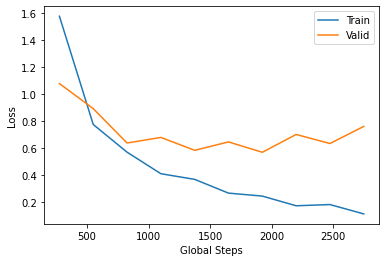

Model loaded from <== ./bertimbau_all_categ/amostra_2/metrics.pt


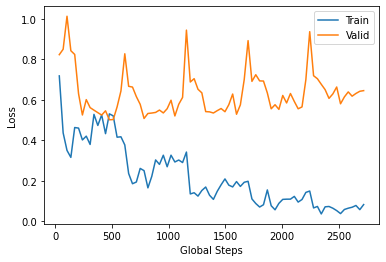

Model loaded from <== ./bertimbau_all_categ/amostra_3/metrics.pt


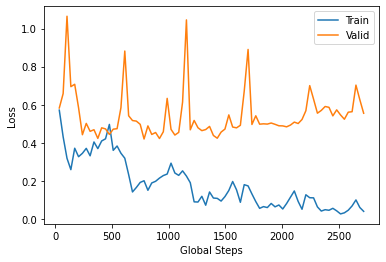

Model loaded from <== ./bertimbau_all_categ/amostra_4/metrics.pt


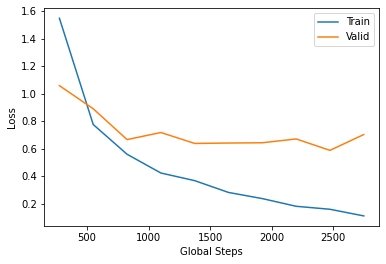

In [100]:
for amostra in range(1,qtd_amostra+1):
  train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder+str(amostra) + '/metrics.pt')
  plt.plot(global_steps_list, train_loss_list, label='Train')
  plt.plot(global_steps_list, valid_loss_list, label='Valid')
  plt.xlabel('Global Steps')
  plt.ylabel('Loss')
  plt.title = 'Resultado do Treino da amostra ' + str(amostra)
  plt.legend()
  plt.show() 

### Avaliação

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_all_categ/amostra_1/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.8142    0.8288    0.8214       111
           1     0.6667    0.5789    0.6197       114
           2     0.7739    0.8990    0.8318        99
           3     0.9271    0.9570    0.9418        93
           4     0.9381    0.8198    0.8750       111
           5     0.7477    0.8989    0.8163        89
           6     0.9100    0.8750    0.8922       104
           7     0.9574    0.9375    0.9474        96
           8     0.9359    0.7604    0.8391        96
           9     0.6636    0.8256    0.7358        86
          10     0.9681    0.9010    0.9333       101

    accuracy                         0.8391      1100
   macro avg     0.8457    0.8438    0.8412      1100
weighted avg     0.8465    0.8391    0.8394      1100



Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_all_categ/amostra_2/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.8440    0.8288    0.8364       111
           1     0.6630    0.5351    0.5922       114
           2     0.7280    0.9192    0.8125        99
           3     0.9570    0.9570    0.9570        93
           4     0.8264    0.9009    0.8621       111
           5     0.7653    0.8427    0.8021        89
           6     0.9053    0.8269    0.8643       104
           7     0.9583    0.9583    0.9583        96
           8     0.9398    0.8125    0.8715        96
           9     0.6915    0.7558    0.7222        86
          10     0.9681    0.9010    0.9333       101

    accuracy                         0.8364      1100
   macro avg     0.8406    0.8398    0.8375      1100
weighted avg     0.8398    0.8364    0.8353      1100



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing

Model loaded from <== ./bertimbau_all_categ/amostra_3/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.8291    0.8739    0.8509       111
           1     0.7879    0.6842    0.7324       114
           2     0.8614    0.8788    0.8700        99
           3     0.9388    0.9892    0.9634        93
           4     0.8850    0.9009    0.8929       111
           5     0.7615    0.9326    0.8384        89
           6     0.8649    0.9231    0.8930       104
           7     1.0000    0.9688    0.9841        96
           8     0.9740    0.7812    0.8671        96
           9     0.8590    0.7791    0.8171        86
          10     0.9423    0.9703    0.9561       101

    accuracy                         0.8782      1100
   macro avg     0.8822    0.8802    0.8787      1100
weighted avg     0.8808    0.8782    0.8771      1100



Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

Model loaded from <== ./bertimbau_all_categ/amostra_4/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.8900    0.8018    0.8436       111
           1     0.7411    0.7281    0.7345       114
           2     0.7155    0.8384    0.7721        99
           3     0.9468    0.9570    0.9519        93
           4     0.8774    0.8378    0.8571       111
           5     0.8462    0.8652    0.8556        89
           6     0.8627    0.8462    0.8544       104
           7     0.9300    0.9688    0.9490        96
           8     0.9157    0.7917    0.8492        96
           9     0.6907    0.7791    0.7322        86
          10     0.9596    0.9406    0.9500       101

    accuracy                         0.8482      1100
   macro avg     0.8523    0.8504    0.8500      1100
weighted avg     0.8528    0.8482    0.8491      1100



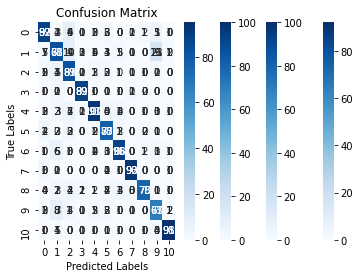

In [102]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in test_loader:
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    n_classe = np.max(y_true)+1
    print(classification_report(y_true, y_pred, labels=np.arange(0,n_classe), digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(0,n_classe))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

%%time    
for amostra in range(1,qtd_amostra+1):    
  best_model = BERT().to(device)

  load_checkpoint(destination_folder+str(amostra) + '/model.pt', best_model)

  evaluate(best_model, token_test[amostra-1])

In [117]:
#!rm ./bertimbau_all_categ/amostra_4/*.*
#!du -sh


1.3G	.
